In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(33)
np.random.seed(33)
random.seed(33)

from library.evaluation import ConfusionMatrix

dataset_name = "Twitter16-TF"
unique_name = "BERT_Finetuned"

c:\Users\msi_b\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vectors = np.loadtxt("../../data/vectors/Twitter16-TF_BERT_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(412, 768)

In [3]:
data = pd.read_csv("../../data/processed/twitter16-tf_dataset.csv", lineterminator="\n")
data.head()

,tweet_id,tweet_text,label,tvt2,tvt2_1,tvt2_2,tvt2_3
0,656955120626880512,correct predictions in back to the future ii U...,False,training,training,training,training
1,615689290706595840,.@whitehouse in rainbow colors for #scotusmarr...,True,testting,testting,training,testting
2,613404935003217920,cops bought the alleged church shooter burger ...,False,validation,training,training,training
3,614467824313106432,god put a rainbow over the white house 🌈 URL\r,True,validation,training,training,training
4,622891631293935616,#wakeupamerica🇺🇸 who needs a #gun registry whe...,False,training,testting,training,training


In [4]:
labels_str = [True, False]
labels_str

[True, False]

In [5]:
labels = []
for i, d in data.iterrows():
    lab = labels_str.index(d['label'])
#     labels.append([1 if j == lab else 0 for j in range(len(labels_str))])
    labels.append(lab)
labels[:10]

[1, 0, 1, 0, 1, 0, 0, 1, 1, 0]

In [6]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(275, 768)
(98, 768)
(39, 768)
(275,)
(98,)
(39,)


In [8]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNModel(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int = 1
    ):
        super(NNModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(128),
            nn.Dropout(p=0.5),
            nn.Linear(128, n_output)
        )

    def forward(self, input):
        return self.main(input)
    

class NNClassifier:
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = NNModel(n_input, n_output)

        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        print(f"loading model from {filepath}...")
#         print(checkpoint[key])
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            for idx, (inputs, targets) in enumerate(trainloader):
                self.optimizer.zero_grad()
                inputs, targets=inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                _, predicted = outputs.max(1)
                train_loss += loss.item()
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()
            
            train_acc=100.*train_correct/train_total
            train_accs.append(train_acc)
            train_losses.append(train_loss/len(trainloader))
            

            self.model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            # test_acc = 0
            with torch.no_grad():
                for idx, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets.long())
                    test_loss += loss.item()
            
                    _, predicted = outputs.max(1)
                    test_total += targets.size(0)
                    test_correct += predicted.eq(targets).sum().item()
                
            test_acc=100.*test_correct/test_total
            test_accs.append(test_acc)
            test_losses.append(test_loss/len(testloader))
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train_Accuracy : {train_acc}, Test Accuracy : {test_acc}, Train Loss : {train_loss}, Test Loss : {test_loss}")

            # Save checkpoint.
            # if saves and test_loss < best_loss:
            #     print(f"Saving after new best loss : {test_loss}")
            #     best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/{saves}.pth")
            
            if epoch >= n_iter:
                break
            
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_accs))], train_accs, label='Training Accuracy')
        ax2.plot([i for i in range(len(test_accs))], test_accs, label='Validation Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Accuracy Over Time (epoch)")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Accuracy/{dataset_name}_4LayerNet_L2Reg_{unique_name}_Accuracy_Graph.png")
        
        # visualizing loss over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_losses))], train_losses, label='Training Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, label='Validation Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Loss Over Time (epoch)")
        ax2.legend(loc='center right')

        plt.show()
        fig.savefig(f"../../Grafik/Loss/{dataset_name}_4LayerNet_L2Reg_{unique_name}_Loss_Graph.png")
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

Multiclass Classification using 4-Layer Linear Network
Using cuda
Saving after new best accuracy : 47.95918367346939
Saving after new best accuracy : 52.04081632653061
Saving after new best accuracy : 72.44897959183673
Saving after new best accuracy : 83.6734693877551
Saving after new best accuracy : 84.6938775510204
Saving after new best accuracy : 85.71428571428571
-- Epoch 50, Train_Accuracy : 100.0, Test Accuracy : 84.6938775510204, Train Loss : 0.002392904367297888, Test Loss : 0.9140769243240356
-- Epoch 100, Train_Accuracy : 100.0, Test Accuracy : 84.6938775510204, Train Loss : 0.0005038570379838347, Test Loss : 1.1679961681365967
-- Epoch 150, Train_Accuracy : 100.0, Test Accuracy : 83.6734693877551, Train Loss : 0.0001263396698050201, Test Loss : 1.3207056522369385
-- Epoch 200, Train_Accuracy : 100.0, Test Accuracy : 83.6734693877551, Train Loss : 0.00029255126719363034, Test Loss : 1.4341750144958496
-- Epoch 250, Train_Accuracy : 100.0, Test Accuracy : 83.6734693877551, Tra

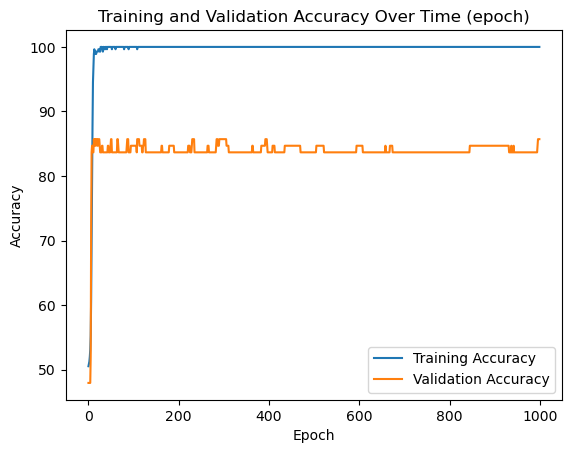

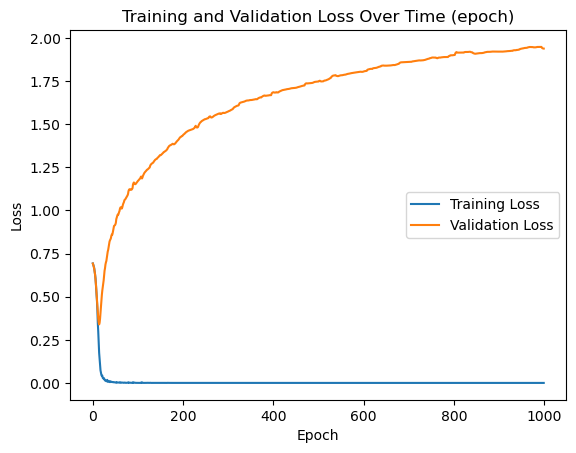

Exec Time : 12.54 seconds
loading model from ../../data/models/Twitter16-TF_4LayerNet_L2Reg_BERT_Finetuned.pth...

Train Set
Predictions : torch.Size([275])
Binary Class Evaluation

True Positive : 134
False Positive : 2
False Negative : 0
True Negative : 139

Class False Evaluation
- Precision : 98.529 %
- Recall : 100.0 %
- F1 : 0.99259

Class True Evaluation
- Precision : 100.0 %
- Recall : 98.582 %
- F1 : 0.99286

Combined Evaluation
- Accuracy : 99.273 %
- Precision : 99.265 %
- Recall : 99.291 %
- F1 : 0.99278
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter16-TF_4LayerNet_L2Reg_BERT_Finetuned Train, 99.273, 99.265, 99.291, 0.99278, 98.529, 100.0, 0.99259, 100.0, 98.582, 0.99286, 
Confusion Matrix Scikit-learn: 
[[139   2]
 [  0 134]]


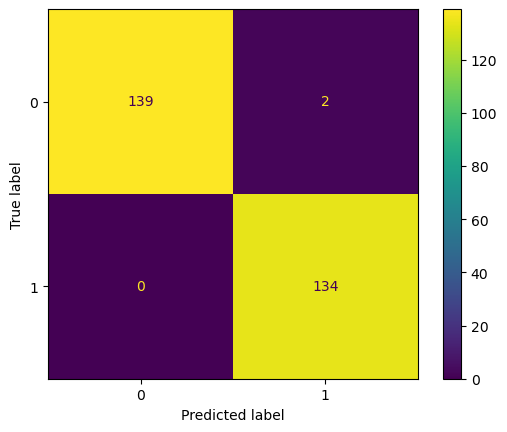


Validation Set
Predictions : torch.Size([98])
Binary Class Evaluation

True Positive : 44
False Positive : 7
False Negative : 7
True Negative : 40

Class False Evaluation
- Precision : 86.275 %
- Recall : 86.275 %
- F1 : 0.86275

Class True Evaluation
- Precision : 85.106 %
- Recall : 85.106 %
- F1 : 0.85106

Combined Evaluation
- Accuracy : 85.714 %
- Precision : 85.69 %
- Recall : 85.69 %
- F1 : 0.8569
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter16-TF_4LayerNet_L2Reg_BERT_Finetuned Validation, 85.714, 85.69, 85.69, 0.8569, 86.275, 86.275, 0.86275, 85.106, 85.106, 0.85106, 
Confusion Matrix Scikit-learn: 
[[40  7]
 [ 7 44]]


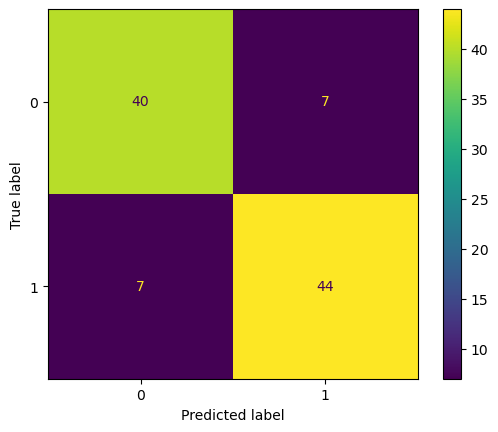


Test Set
Predictions : torch.Size([39])
Binary Class Evaluation

True Positive : 19
False Positive : 0
False Negative : 1
True Negative : 19

Class False Evaluation
- Precision : 100.0 %
- Recall : 95.0 %
- F1 : 0.97436

Class True Evaluation
- Precision : 95.0 %
- Recall : 100.0 %
- F1 : 0.97436

Combined Evaluation
- Accuracy : 97.436 %
- Precision : 97.5 %
- Recall : 97.5 %
- F1 : 0.975
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter16-TF_4LayerNet_L2Reg_BERT_Finetuned Test, 97.436, 97.5, 97.5, 0.975, 100.0, 95.0, 0.97436, 95.0, 100.0, 0.97436, 
39
39
Confusion Matrix Scikit-learn: 
[[19  0]
 [ 1 19]]


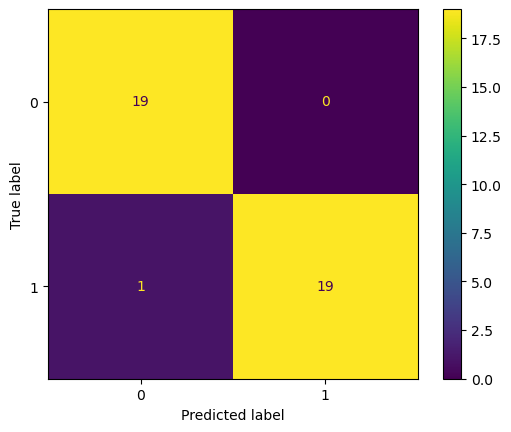

In [9]:
print("Multiclass Classification using 4-Layer Linear Network")
start = time.time()
model_name = f"{dataset_name}_4LayerNet_L2Reg_{unique_name}"
model = NNClassifier(train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss)
model.train_eval(torch.Tensor(train_vectors),
                torch.Tensor(train_labels),
                torch.Tensor(val_vectors),
                torch.Tensor(val_labels),
                saves=model_name,
                n_iter=1000,
                batch_size=512)
print(f"Exec Time : {round(time.time() - start, 2)} seconds")

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\nTrain Set")
preds = model.predict(train_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=np.array(train_labels),
    predictions=np.array(preds),
    binary=True,
    model_name=f"{model_name} Train"
)
conf_mat.evaluate(classes=labels_str)

labels=np.array(train_labels)
predictions=np.array(preds)
cm = confusion_matrix(labels, predictions, labels=[0,1])
print(f'Confusion Matrix Scikit-learn: \n{cm}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

print("\nValidation Set")
preds = model.predict(val_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=np.array(val_labels),
    predictions=np.array(preds),
    binary=True,
    model_name=f"{model_name} Validation"
)
conf_mat.evaluate(classes=labels_str)

labels=np.array(val_labels)
predictions=np.array(preds)
cm = confusion_matrix(labels, predictions, labels=[0,1])
print(f'Confusion Matrix Scikit-learn: \n{cm}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

print("\nTest Set")
preds = model.predict(test_vectors)
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=np.array(test_labels),
    predictions=np.array(preds),
    binary=True,
    model_name=f"{model_name} Test"
)
conf_mat.evaluate(classes=labels_str)

labels=np.array(test_labels)
predictions=np.array(preds)
print(len(labels))
print(len(predictions))
cm = confusion_matrix(labels, predictions, labels=[0,1])
print(f'Confusion Matrix Scikit-learn: \n{cm}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()